In [1]:
import numpy as np
import matplotlib.pyplot as plt
import orthopy,quadpy

As a prime basis, we will start with the hexahedral basis from (Wheeler, Xue & Yotov, 2012) which has a dimension of 24.

In [2]:
def WheelerXueYotov(x,y,z):
    V = np.zeros((3,x.size,24))
    O = np.zeros(x.size)
    for d in range(3):
        V[d,:,4*d+0] = np.ones(x.size)
        V[d,:,4*d+1] = x
        V[d,:,4*d+2] = y
        V[d,:,4*d+3] = z
    V[...,12] = [     x*z,     -y*z,        O] # curl(0       ,0       ,x*y*z   )
    V[...,13] = [   2*x*y,    -y**2,        O] # curl(0       ,0       ,x*y**2  )
    V[...,14] = [       O,   -2*x*z,        O] # curl(0       ,0       ,x**2*z  )
    V[...,15] = [  x**2*z, -2*x*y*z,        O] # curl(0       ,0       ,x**2*y*z)
    V[...,16] = [       O,      x*y,     -x*z] # curl(x*y*z   ,0       ,0       )
    V[...,17] = [       O,    2*y*z,    -z**2] # curl(y*z**2  ,0       ,0       )
    V[...,18] = [       O,        O,   -2*x*y] # curl(x*y**2  ,0       ,0       )
    V[...,19] = [       O,   x*y**2, -2*x*y*z] # curl(x*y**2*z,0       ,0       )
    V[...,20] = [    -x*y,        O,      y*z] # curl(0       ,x*y*z   ,0       )
    V[...,21] = [   -x**2,        O,    2*x*z] # curl(0       ,x**2*z  ,0       )
    V[...,22] = [  -2*y*z,        O,        O] # curl(0       ,y*z**2  ,0       )
    V[...,23] = [-2*x*y*z,        O,   y*z**2] # curl(0       ,x*y*z**2,0       ) 
    return V

We will take this hexahedral space and constraint it like in (Kriby, 2004). First we setup contraint equations on the top and bottom faces to remove $xy$ terms from the normal components.

In [3]:
# we should need 6 conditions to restrict the full hex space to a prism, for now I have 5
C = np.zeros((6,24))

# quadrature for the top face of the prism
scheme = quadpy.triangle.seven_point()
quad   = scheme.points @ np.asarray([[-1,-1],[+1,-1],[-1,+1]]) # to cartesian
xq,yq  = quad[:,0],quad[:,1]; zq = np.ones(xq.shape)
bary   = np.asarray([(xq+1)/2,(yq+1)/2,1-(xq+1)/2-(yq+1)/2]) # to barycentric
poly   = orthopy.triangle.tree(bary,3,"normal")[2] # orthogonal to {1,x,y} but not {xy}
which_poly = 0 # could also be 2, but not 1

# constraint 0: no xy on top face
P = WheelerXueYotov(xq,yq,zq)
for j in range(P.shape[2]):
    C[0,j] = ((P[...,j].T @ [0,0,+1])*poly[which_poly]*scheme.weights).sum()
    
# constraint 1: no xy on bottom face
zq *= -1
P   = WheelerXueYotov(xq,yq,zq)
for j in range(P.shape[2]):
    C[1,j] = ((P[...,j].T @ [0,0,-1])*poly[which_poly]*scheme.weights).sum()

These 2 constraints are non-zero for basis 18 and 19, which are the only functions with $xy$ contributions in the $z$-component. Both the 0 and 2 2nd order Legendre polynomial work here (can change above with `which_poly`). The 1 polynomial is $xy$ which keeps the part we want to remove. Below we plot the constraint matrix, the singular values, and the right singular vectors.

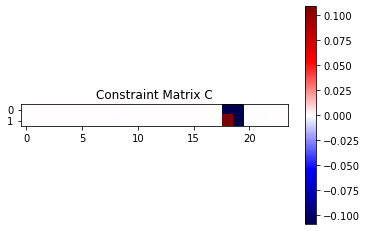

Singular values: [0.15396007 0.15396007]


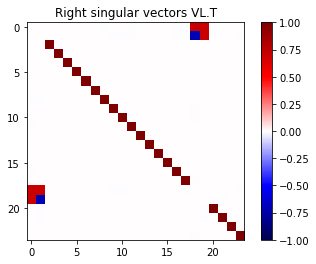

In [4]:
c = C[:2]
mag = np.abs(c).max()
cb = plt.imshow(c,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.title("Constraint Matrix C")
plt.show()

UL,SL,VL = np.linalg.svd(c)
print("Singular values:",SL)

mag = np.abs(VL).max()
cb = plt.imshow(VL.T,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.title("Right singular vectors VL.T")
plt.show()

Now we need 4 more constraints for the diagonal face. So I setup quadrature for the face and evaluate 2nd and 3rd order orthogonal polynomials at these points. According to my tests on another sheet, we need 3 Legendre polynomials to remove the unwanted terms on the diagonal face. First I will add two constraints using the 0 2nd order polynomial and the 1 3rd order polynomial. These lead to positive singular values.

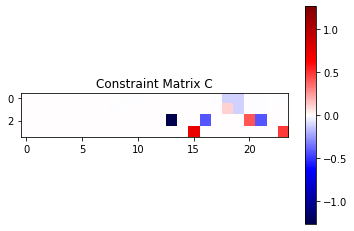

Singular values: [1.46059349 0.87770745 0.15396007 0.15396007]


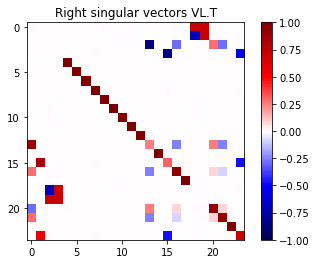

In [6]:
x1d,w1d = np.polynomial.legendre.leggauss(7)
x2d,y2d = np.meshgrid(x1d,x1d); x2d = x2d.flatten(); y2d = y2d.flatten()
w2d = (w1d[:,np.newaxis]*w1d).flatten()
poly = orthopy.quadrilateral.tree(np.asarray([x2d,y2d]),3) # on [-1,+1]^2
orth = [poly[2][0],poly[3][1]]

Xq  = np.asarray([+1,-1,-1])[:,np.newaxis] * (0.25*(1-x2d)*(1-y2d))
Xq += np.asarray([-1,+1,-1])[:,np.newaxis] * (0.25*(1+x2d)*(1-y2d))
Xq += np.asarray([+1,-1,+1])[:,np.newaxis] * (0.25*(1-x2d)*(1+y2d))
Xq += np.asarray([-1,+1,+1])[:,np.newaxis] * (0.25*(1+x2d)*(1+y2d))
xq = Xq[0,:]; yq = Xq[1,:]; zq = Xq[2,:]
P  = WheelerXueYotov(xq,yq,zq)
s  = 1/np.sqrt(2)
for i in range(len(orth)):
    C[i+2,:] = ((P.T @ [s,s,0]) * orth[i] * w2d).sum(axis=1)
    
c = C[:4]
mag = np.abs(c).max()
cb = plt.imshow(c,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.title("Constraint Matrix C")
plt.show()

UL,SL,VL = np.linalg.svd(c)
print("Singular values:",SL)

mag = np.abs(VL).max()
cb = plt.imshow(VL.T,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.title("Right singular vectors VL.T")
plt.show()

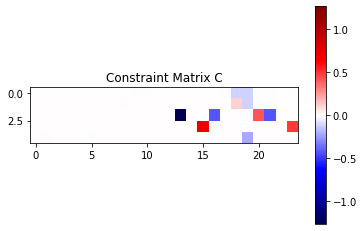

Singular values: [1.46059349e+00 8.77707451e-01 2.63472939e-01 1.53960072e-01
 3.30383551e-15]


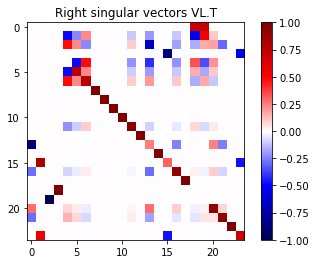

In [7]:
orth = [poly[3][0]]
for i in range(len(orth)):
    C[i+4,:] = ((P.T @ [s,s,0]) * orth[i] * w2d).sum(axis=1)
    
c = C[:5]
mag = np.abs(c).max()
cb = plt.imshow(c,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.title("Constraint Matrix C")
plt.show()

UL,SL,VL = np.linalg.svd(c)
print("Singular values:",SL)

mag = np.abs(VL).max()
cb = plt.imshow(VL.T,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.title("Right singular vectors VL.T")
plt.show()